In [1]:
# Import required packages
from __future__ import print_function
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt

from IPython.display import display, Math #


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, recall_score, precision_score, f1_score
from sklearn.utils import shuffle

from sklearn.svm import LinearSVC, NuSVC, SVC, OneClassSVM

In [2]:
# Setup pandas options
pd.options.display.max_rows = 5
pd.options.display.max_columns = 10
pd.options.display.float_format = '{:.3f}'.format

In [9]:
PT_data = pd.read_excel("PTData01.xlsx")
PT_data = shuffle(PT_data)
targets = PT_data.iloc[:,5:-1]
targets_headers = targets.columns.values.tolist()

Data_Cell = pd.read_excel("Data_Colleff_Entire.xlsx") 
meanWater = np.zeros(len(targets_headers))
for h in range(len(targets_headers)):
    meanWater[h] = np.mean(Data_Cell.values[:,h+5])


In [10]:
def my_classification(PT_data, my_model):
    
    

    data_split = []
    for i in range(10):
        data_split.append(PT_data.iloc[i*100:(i+1)*100])

    targets = PT_data.iloc[:,5:-1]
    targets_headers = targets.columns.values.tolist()
    number_loc = len(targets_headers)

    ERROR = np.zeros(number_loc)
#     print('Training/testing with 10 groups of data')
#     print('classifying group number: ')
    for split in range(len(data_split)):
#         print('  - ' + str(split))
        d = data_split[split]
        training = d.iloc[0:70]
        testing = d.iloc[70:100]
        number_training_samples = len(training.iloc[:,0])
        number_testing_samples = len(testing.iloc[:,0])


        training_features = training.iloc[:,0:5]
        training_target = training.iloc[:,5:-1]
        testing_features = testing.iloc[:,0:5]
        testing_target = testing.iloc[:,5:-1]

    #     model = SVC(kernel='rbf', degree=2, gamma=0.01) 
        model = my_model
        for i_loc in range(number_loc):
            trn_target = training_target.iloc[:,i_loc]
            tst_target = testing_target.iloc[:,i_loc]

            abcissa = targets_headers[i_loc]
            training_features['abscissa'] = np.ones(len(training_features.iloc[:,0]))*abcissa
            testing_features['abscissa'] = np.ones(len(testing_features.iloc[:,0]))*abcissa


            # if trn_target = [0,0,...,0,0] then prediction = [0,0,...,0,0]
#             if np.sum(np.asarray(trn_target)) == 0 or np.sum(np.asarray(trn_target)) == len(trn_target):
            if np.sum(np.asarray(trn_target)) == 0:
                index = randint(0,len(trn_target)-1)
#                 label = np.unique(trn_target)
#                 average_label = 'weighted'
                trn_target.iloc[index] = 1


            # if trn_target = [1,1,...,1,1] then prediction = [1,1,...,1,1]
            if np.sum(np.asarray(trn_target)) == len(trn_target):
                index = randint(0,len(trn_target)-1)
#                 label = np.unique(trn_target)
#                 average_label = 'weighted'
                trn_target.iloc[index] = 0
            else:
                average_label = 'binary'

            #Fit model
            model.fit(training_features, trn_target)
            #Comparing prediction with testing values
            prediction = model.predict(testing_features)
    #         print(prediction, i_loc)

             #Get error
            if  np.sum(tst_target) == 0:
                metric = 0
            else:
                metric = recall_score(tst_target, prediction)
            ERROR[i_loc] += metric

    #average error through all samples
    ERROR /= 10
    min_ERROR = np.min(ERROR)
    return ERROR, min_ERROR

gamma 0.0001
gamma 1
gamma 10
gamma 20
gamma 0.0001
gamma 1
gamma 10
gamma 20
gamma 0.0001
gamma 1
gamma 10
gamma 20
gamma 0.0001
gamma 1
gamma 10
gamma 20

Recall for SVC with polynomial kernel with degree 1 for different values of C and gamma


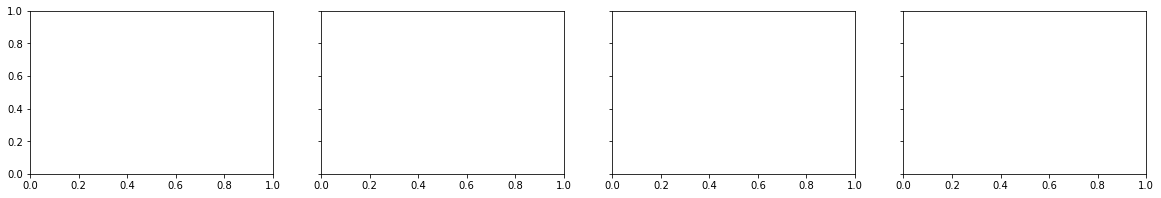

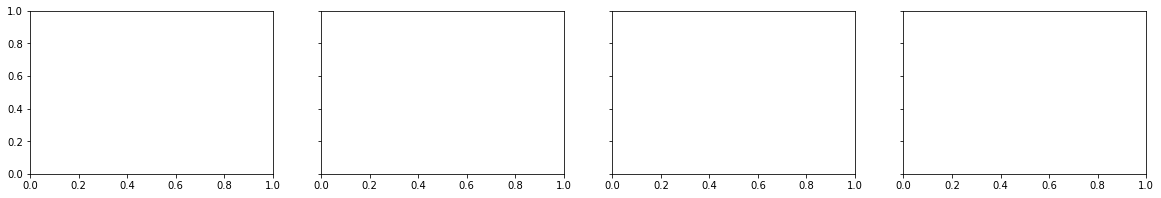

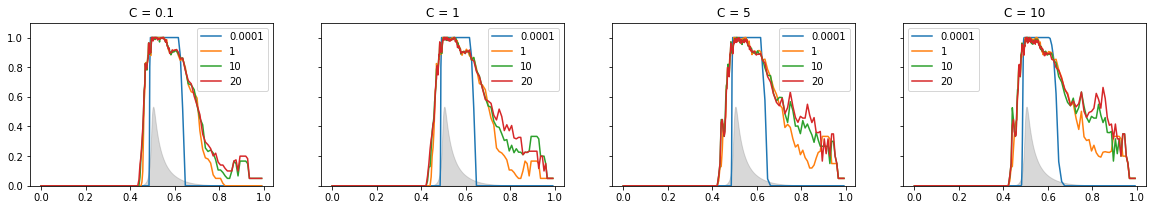

In [11]:
gamma_vector = [0.0001, 1, 10, 20]
C_vector = [0.1, 1, 5, 10]

fig, axs = plt.subplots(1, 4, figsize=(20, 3), sharey=True)


# model = LinearSVC(random_state=0, tol=1e-5)

vector_ERROR = []
degree = 1
kernel='poly'
for j in range(len(C_vector)):
    c = C_vector[j]
    for i in range(len(gamma_vector)):
        gamma = gamma_vector[i]
        label = str(gamma)
        print('gamma ' + str(gamma))
        model = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma)
        ERROR, min_ERROR = my_classification(PT_data, model)
        axs[j].plot(targets_headers, ERROR, label = label)
        vector_ERROR.append(ERROR)
    axs[j].title.set_text('C = ' + str(c))
    axs[j].fill_between(targets_headers, 0, meanWater, color='gray', alpha=0.3)
    axs[j].legend()

print()
print(r'Recall for SVC with polynomial kernel with degree ' + str(degree) + \
          ' for different values of C and gamma')

plt.ylim(0,1.1)    
plt.legend()
plt.show()

gamma 0.0001
gamma 1
gamma 10
gamma 20
gamma 0.0001
gamma 1
gamma 10
gamma 20
gamma 0.0001
gamma 1
gamma 10
gamma 20
gamma 0.0001
gamma 1
gamma 10
gamma 20

Recall for SVC with gaussian kernel and for different values of C and gamma


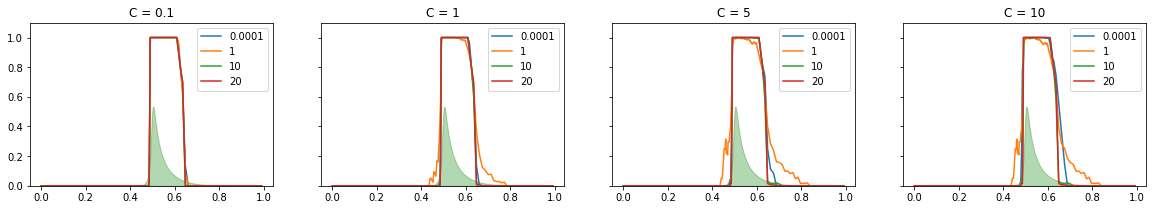

In [246]:
gamma_vector = [0.0001, 1, 10, 20]
C_vector = [0.1, 1, 5, 10]

fig, axs = plt.subplots(1, 4, figsize=(20, 3), sharey=True)


# model = LinearSVC(random_state=0, tol=1e-5)

vector_ERROR = []
degree = 1
kernel='rbf'
for j in range(len(C_vector)):
    c = C_vector[j]
    for i in range(len(gamma_vector)):
        gamma = gamma_vector[i]
        label = str(gamma)
        print('gamma ' + str(gamma))
        model = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma)
        ERROR, min_ERROR = my_classification(PT_data, model)
        axs[j].plot(targets_headers, ERROR, label = label)
        vector_ERROR.append(ERROR)
    axs[j].title.set_text('C = ' + str(c))
    axs[j].fill_between(targets_headers, 0, meanWater, color='g', alpha=0.3)
    axs[j].legend()

print()
print(r'Recall for SVC with gaussian kernel and ' + \
      'for different values of C and gamma')

plt.ylim(0,1.1)    
plt.legend()
plt.show()

In [197]:
Data_Cell = pd.read_excel("Data_Colleff_Entire.xlsx") 
targets = PT_data.iloc[:,5:-1]
targets_headers = targets.columns.values.tolist()
meanWater = np.zeros(len(targets_headers))
for h in range(len(targets_headers)):
    meanWater[h] = np.mean(Data_Cell.values[:,h+5])

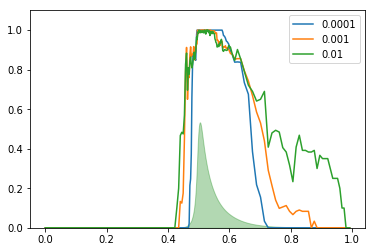

In [198]:
for i in range(len(vector_ERROR)):
    errors = vector_ERROR[i]
    label = str(gamma_vector[i])
    plt.plot(targets_headers,errors, label = label)
plt.legend()
plt.fill_between(targets_headers, 0, meanWater, color='g',alpha=0.3)
plt.ylim(0,1.1)
plt.show()